## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [3]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [4]:
# The CNN for detecting facial keypoints in defined in models.py
from models import Net

# Set to first GPU on my own rig, to help speed up training. Using a Titan XP which saves a lot of time.
# The device identifier will be used to move tensors and network models to the GPU after creation.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create CNN and move to GPU if available
net = Net()
net.to(device)

print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.1)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.2)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0.3)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop4): Dropout(p=0.4)
  (dense1): Linear(in_features=43264, out_features=7000, bias=True)
  (drop5): Dropout(p=0.5)
  (dense2): Linear(in_features=7000, out_features=1000, bias=True)
  (drop6): Dropout(p=0.6)
  (output): Linear(in_features=1000, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

## Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


# Define two separate data transformations, one for training and for testing
# The training data_transform will first rescale the image to 256x256, then random crop to 224x224
# which is the required input size for the defined CNN, normalize, and then convert to a (1, 224, 224) 
# tensor. The test data data transform is missing the random crop so we can have reproducible test 
# data to bench mark the test loss after each epoch.

# Training data transform
data_transform = transforms.Compose([Rescale((256, 256)), RandomCrop((224, 224)), Normalize(), ToTensor()])

# Test data transform
test_data_transform = transforms.Compose([Rescale((224, 224)), Normalize(), ToTensor()])


# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [6]:
# create the transformed training dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [7]:
# load training data in batches, we will train with batch size of 10
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [8]:
# load in the test data, using the dataset class
# and apply the test_data_transform defined above, which does not have the random cropping

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=test_data_transform)



In [9]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [10]:
# test the model on a batch of test images

def net_sample_output():
    print("net_sample_output entered...")
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        print("batch number {}".format(i))
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.cuda.FloatTensor)

        print("feedforward input, images.size() -> {}".format(images.size()))
        
        # forward pass to get net output
        #images = images[0:1,:,:,:]
        output_pts = net(images)
        
        print("network output, output_pts.size() -> {}".format(output_pts.size()))
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [11]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print('test_images.data.size() -> {}'.format(test_images.data.size()))
print('test_outputs.data.size() -> {}'.format(test_outputs.data.size()))
print('gt_pts.size() -> {}'.format(gt_pts.size()))
test_images.size(0)

net_sample_output entered...
batch number 0
feedforward input, images.size() -> torch.Size([10, 1, 224, 224])
network output, output_pts.size() -> torch.Size([10, 136])
test_images.data.size() -> torch.Size([10, 1, 224, 224])
test_outputs.data.size() -> torch.Size([10, 68, 2])
gt_pts.size() -> torch.Size([10, 68, 2])


10

## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [12]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
        
    # plot the predicted facial keypoints as magenta points
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

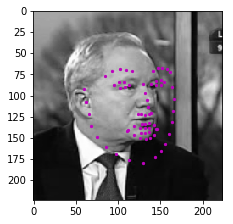

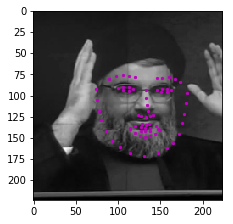

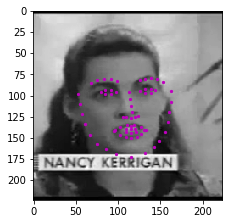

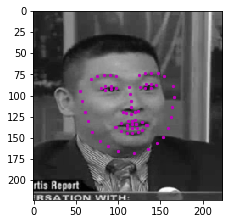

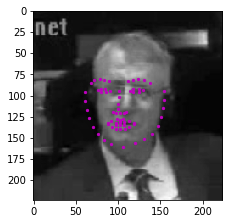

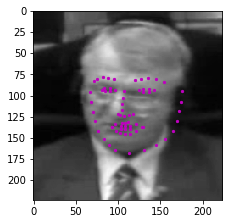

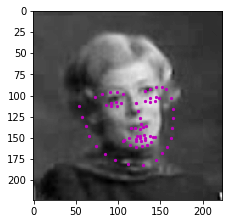

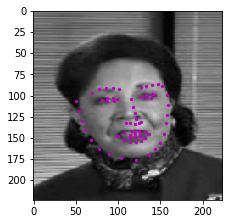

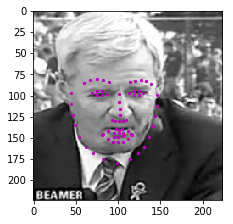

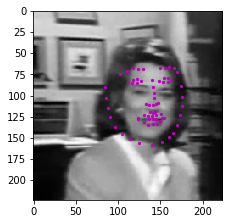

In [13]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(test_images.size(0)):
        plt.figure(figsize=(40,20))

        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.cpu().numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.cpu().numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        #plt.axis('off')

    plt.show()
    
# test out the visualize function
visualize_output(test_images, test_outputs, gt_pts=None)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [14]:
## Define the loss and optimization
import torch.optim as optim

# Use mean squared error loss, to determine error (distance off) between coordinates of
# predicted facial keypoints and the ground truth coordinates
criterion = nn.MSELoss()

# Using the Adam optimizer which has built-in self adjusting learning rate. Starting with lr=0.001
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

### Validation Function
The following is used to perform validation of the the entire test dataset using the trained CNN.  The test_net functioneturns the MSE test loss for all test samples, which is used to evaluate the network after each epoch of training.

This is helper function which will be used in the train_net function below to train our network, and record the test loss at end of each epoch.

In [15]:
def test_net(net, test_loader, critereon):
    '''Perform validation of the the entire test dataset using the trained CNN.  Returns the
    test loss, which is used to evaluate the network after each epoch of training.
    
    ARGUMENTS:
        net - the CNN model
        test_loader - used to get all test samples in batches, with transformations applied
        critereon - reference to the loss function we're using (MSELoss)
    '''
    # Track the running loss for all batches of test samples. Use this to sum up the total
    # loss for all test samples.
    running_loss = 0.0
    
    # Track the total samples
    total_test_samples = 0

    # Loop through all test samples from the test_loader, one batch at a time
    for batch_i, data in enumerate(test_loader):
        # Conver to FloatTensor and move to GPU (if available)
        images = data['image'].type(torch.FloatTensor).to(device)
        
        # flatten pts and convert to float tensor and move to GPU (if available)
        gt_keypts = data['keypoints'].view(data['keypoints'].size(0), -1)
        gt_keypts = gt_keypts.type(torch.FloatTensor).to(device)
        
        # get samples from this batch (could be less than batch size)
        samples = len(images)
        
        # get predicted facial keypoints for batch of input image tensors
        # with a feed forward on batch of test input images
        predicted_keypts = net(images)
        
        # calculate MSE loss for this batch of test samples
        # note we un-normalize the keypoint coordinate values first, so that the loss is in 
        # pixel units which is more intuitive
        loss = critereon(predicted_keypts*50.+100., gt_keypts*50.+100.)
        
        # track the the total running loss, note we undo the mean part, so running_loss
        # represents total loss for all samples tested so far
        running_loss += loss.item() * samples
        total_test_samples += samples
        
    # Now compute the average of the running loss, which gives us MSE loss for all test 
    # samples, and return
    test_loss = running_loss / total_test_samples
    return test_loss
    
    
test_net(net, test_loader, criterion)    

57.24721323979365

### Training Function

This function trains the CNN network for given number of epochs. Returns the train and test loss for each epoch as lists.

In [16]:
def train_net(n_epochs):
    '''This function trains the CNN network for given number of epochs. Returns the train and test loss 
    for each epoch as lists.
    
    ARGUMENTS:
        n_epochs - number of epochs to train for
        
    RETURNS:
        train_loss_hist - list, train loss at end of each epoch
        test_loss_hist - list, test loss at end of each epoch
    
    '''

    # track train and test loss after each epoch
    train_loss_hist = []
    test_loss_hist = []
    
    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        total_samples = 0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            samples = len(images)
            
            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor).to(device)
            images = images.type(torch.FloatTensor).to(device)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts*50+100, key_pts*50+100)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # update the total running loss so far
            running_loss += loss.item() * samples
            total_samples += samples
            
        # after each epoch, compute the average test and train loss, and record in 
        # train_loss_hist and test_loss_hist
        test_loss = test_net(net, test_loader, criterion)
        train_loss = running_loss/total_samples
        train_loss_hist.append(train_loss)
        test_loss_hist.append(test_loss)
        
        # print out feedback after each epoch
        print('Epoch: {}, Train Loss: {}, Test Loss: {}'.format(epoch + 1, train_loss, test_loss))
                
    print('Finished Training')
    
    # return the historical train and test loss for each epoch for analysis
    return train_loss_hist, test_loss_hist


### Train The Network


In [17]:
# train  network
n_epochs = 200 # 200 works pretty well with various testing
train_loss_hist, test_loss_hist = train_net(n_epochs)

Epoch: 1, Train Loss: 390.40379556515944, Test Loss: 183.49360250497793
Epoch: 2, Train Loss: 314.74548532451803, Test Loss: 152.09530887356053
Epoch: 3, Train Loss: 288.20036673807533, Test Loss: 142.43880621179358
Epoch: 4, Train Loss: 268.55486103236365, Test Loss: 141.55118214000356
Epoch: 5, Train Loss: 250.22268628275236, Test Loss: 142.75324070918094
Epoch: 6, Train Loss: 249.97693268210125, Test Loss: 140.43076809969816
Epoch: 7, Train Loss: 244.82054525162704, Test Loss: 137.42593998103948
Epoch: 8, Train Loss: 233.93179417372713, Test Loss: 156.51293558888622
Epoch: 9, Train Loss: 226.1092945938507, Test Loss: 152.33624178403383
Epoch: 10, Train Loss: 226.29730003793276, Test Loss: 141.33180920489423
Epoch: 11, Train Loss: 193.35083580347654, Test Loss: 125.25733680229682
Epoch: 12, Train Loss: 175.85175874424698, Test Loss: 113.01680156162807
Epoch: 13, Train Loss: 164.39652718511502, Test Loss: 113.42934774423574
Epoch: 14, Train Loss: 150.0391039129353, Test Loss: 103.1800

Epoch: 116, Train Loss: 76.88568936463108, Test Loss: 65.95346609338537
Epoch: 117, Train Loss: 72.89852889406413, Test Loss: 60.9716755755536
Epoch: 118, Train Loss: 72.46919600444333, Test Loss: 65.51216702647024
Epoch: 119, Train Loss: 73.4357582898859, Test Loss: 58.91884687349394
Epoch: 120, Train Loss: 71.91942467736344, Test Loss: 63.88449723379953
Epoch: 121, Train Loss: 73.43895075074653, Test Loss: 56.16128208110859
Epoch: 122, Train Loss: 74.4640810463485, Test Loss: 59.22548249480012
Epoch: 123, Train Loss: 80.47239636245455, Test Loss: 63.010744169160915
Epoch: 124, Train Loss: 74.36375482780682, Test Loss: 58.265583087871605
Epoch: 125, Train Loss: 72.05906308668325, Test Loss: 63.5932682086895
Epoch: 126, Train Loss: 74.19916809893013, Test Loss: 61.372784503094564
Epoch: 127, Train Loss: 73.03008857123223, Test Loss: 54.11644071108335
Epoch: 128, Train Loss: 74.03531545576232, Test Loss: 58.32670117663098
Epoch: 129, Train Loss: 72.36531468087851, Test Loss: 57.59818178

In [17]:
test_net(net, test_loader, criterion)    

55.33309711109508

### Analysis of Train and Test Loss By Epoch


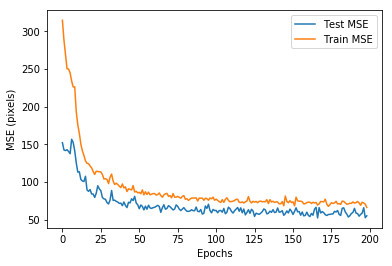

In [25]:
plt.plot(range(len(test_loss_hist[1:])), test_loss_hist[1:], label='Test MSE')
plt.plot(range(len(test_loss_hist[1:])), np.array(train_loss_hist[1:]), label='Train MSE')
plt.xlabel("Epochs")
plt.ylabel("MSE (pixels)")
plt.legend()
plt.show()

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [18]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

net_sample_output entered...
batch number 0
feedforward input, images.size() -> torch.Size([10, 1, 224, 224])
network output, output_pts.size() -> torch.Size([10, 136])
torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


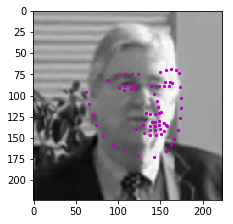

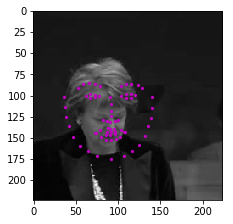

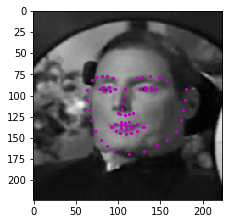

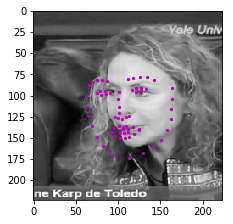

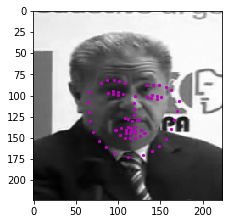

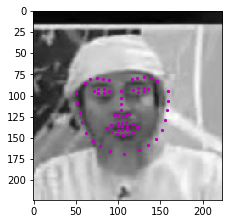

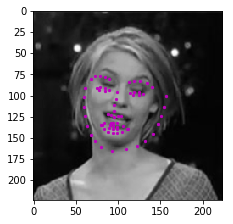

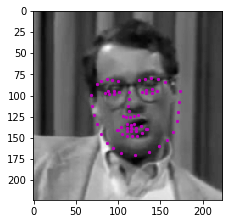

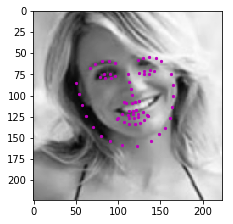

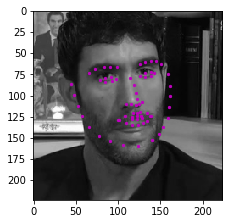

In [19]:
# visualize your test output

visualize_output(test_images, test_outputs, gt_pts=None)


Once you've found a good model (or two), save your model so you can load it and use it later!

In [22]:
## Save our best model. In our case, the best model was trained for 200 epochs, with random crop
model_dir = 'saved_models/'
model_name = 'keypoints_model_200epochs_rndcrop_224x224.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


For the loss function, I chose to use MSE, mean squared error.  This is an appropriate loss function for regression problems, which is what facial keypoint detection is.  Since the facial keypoint labels (ground truth), are given as coordinates of real numbers (or integers), MSE can be used to compute the distance between the the ground truth, and predicted coorindates.  

I also wrote my own custom test_net function, which is used to compute the average MSE for all test samples.  This is used as a validation step at end of each epoch of training, to evalute how well the network is doing with the held out, or unseen test data set.  During computation of the MSE, I track the total running MSE for each batch of test samples, and in the end, divide it by total samples to get the average MSE across all test samples.  The keypoint coorindates are are also de-normalized, so that the MSE value is in units of pixels, which gives us a better intuition of well the the network is predicting keypoints.

For the optimization function, I chose the Adam optimizer, instead of SGD.  Adam has the ability to adjust the learning rate dynamically, which I felt would be beneficial for this problem.


### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

I actually only tried one architecture, based on the referenced paper for Facial Key Points Detection using Deep CNN - NamishNet.  I implemented the network architecture described in the paper using PyTorch directly.  The initial architecture with a low number of epochs of training appeared promising, so I stuck with the NamishNet architecture.  The primary hyperparameters that I turned was the learning rate, number of epochs to train for, and the batch size.

The final learning rate I settled on was 0.001, and 200 epochs, which worked well.  However, this network is expensive to train, and I fortunately had access to a Titan XP, which helped a lot in reducing the training time.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

I ran a number of different iterations with lower epochs (about 20), trying out different batch size and learning rate.  I used the modifications I made to the train_net function, to use my custom test_net function to do validation using the held out test data set.  By examining the the test loss value, lowest specifically, I settled on the a learning rate of 0.001 and batch size of 10.  Note I had increased batch size to 32, which had test loss performance much worse.  

Finally, 200 epochs looks to work out well.  Possibly 150 epochs may be sufficient as well.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.03212555  0.00095603 -0.15169419 -0.24817608]
 [ 0.06593569  0.15097444 -0.24954744 -0.12499619]
 [-0.13507217 -0.10450466 -0.25591454  0.08539738]
 [-0.16033976  0.16670321 -0.24998708 -0.03448173]]
(4, 4)


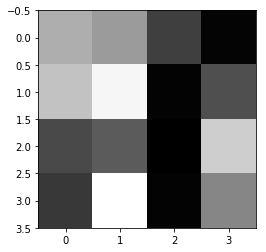

In [42]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.cpu().numpy()

filter_index = 5

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

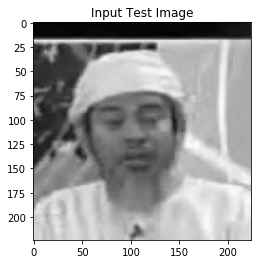

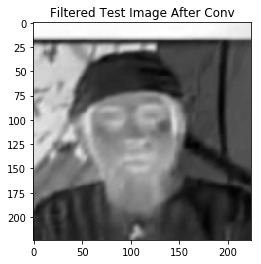

In [43]:
import cv2

# Load 6th test image in test_images batch, that was already loaded by net_sample_output()
test_img = np.squeeze(test_images[5].cpu().numpy())

# Display the test image
plt.imshow(test_img, cmap='gray')
plt.title('Input Test Image')
plt.show()

# Get the first learned kernel (feature map) from our conv1 layer
kernel = w[filter_index][0]

# Convolve the extracted kernel and out test image 
filtered_img = cv2.filter2D(test_img, -1, kernel)

# Display what out filtered image looks like
plt.title('Filtered Test Image After Conv')
plt.imshow(filtered_img, cmap='gray')
plt.show()


### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


I chose the 6th filter, and based on visual representation of that kernel, it looks it detects vertical lines.

After extracting that as a kernel, and convolving with my chosen test image, it appears that it does act as a vertical line detector.  The filtered output image (feature map), looks like it highlights vertical lines.  This filter also seems to have the effect of detecting blobs of similiar color, reversing white to dark, and vice versa.  It specially appears to make the face stand out, and only leaves highlight facial features such as outline of eyes, nose, mouth, and outline of the head, while blurring out the other details of the face.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!